# One neuron

Optimized Weights: [0.11037514 0.65632959]
Predictions: [tensor(1., requires_grad=True), tensor(0.7922373, requires_grad=True), tensor(0.99391485, requires_grad=True), tensor(0.72020072, requires_grad=True)]


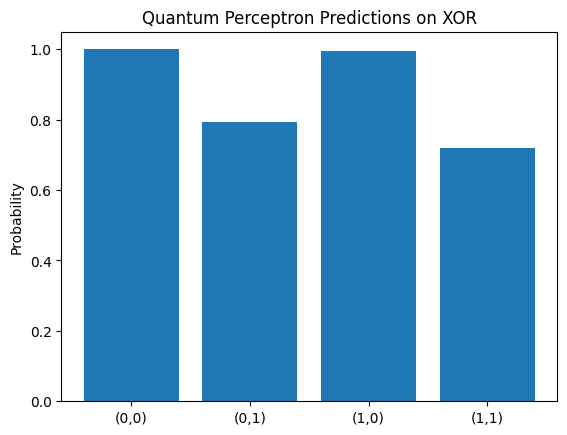

In [31]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
# Define the quantum device
dev = qml.device("default.qubit", wires=1)

# Quantum circuit
@qml.qnode(dev)
def quantum_neuron(weights, inputs):
    qml.RY(inputs[0] * weights[0], wires=0)
    qml.RY(inputs[1] * weights[1], wires=0)
    return qml.expval(qml.PauliZ(0))

# Cost function
def cost(weights, inputs, targets):
    predictions = [quantum_neuron(weights, x) for x in inputs]
    return np.mean((predictions - targets) ** 2)

# Initialize weights and inputs for XOR
weights = np.random.random(size=(2,))
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# Define targets for XOR
targets = np.array([0, 1, 1, 0])

# Optimize the weights to minimize the cost
opt = qml.GradientDescentOptimizer(0.1)
steps = 200

for i in range(steps):
    weights = opt.step(lambda w: cost(w, inputs, targets), weights)

# Print the optimized weights
print("Optimized Weights:", weights)

# Evaluate the quantum neuron with the optimized weights
predictions = [quantum_neuron(weights, x) for x in inputs]
print("Predictions:", predictions)

# Plot the bar chart of predictions
fig, ax = plt.subplots()
ax.bar(range(len(predictions)), predictions, tick_label=['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
ax.set_ylabel('Probability')
ax.set_title('Quantum Perceptron Predictions on XOR')
plt.show()

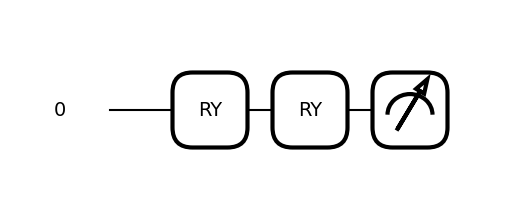

In [50]:
fig, ax = qml.draw_mpl(quantum_neuron)(np.array([0.1, 0.2]),np.array([0.3, 0.4]))
plt.show()

# Two neurons

In [33]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

dev = qml.device("default.qubit", wires=2)

def statepreparation(x):
    qml.BasisState(x, wires=[0, 1])

def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])


@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [35]:
data = [
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
]


data = np.array(data)
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

np.random.seed(0)
num_qubits = 2
num_layers = 6
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.5)

weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    weights, bias, _, _ = opt.step(cost, weights, bias, X, Y)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

print(predictions)


Iter:     1 | Cost: 1.9978443 | Accuracy: 0.5000000 
Iter:     2 | Cost: 1.9318615 | Accuracy: 0.5000000 
Iter:     3 | Cost: 1.0887936 | Accuracy: 0.5000000 
Iter:     4 | Cost: 0.2525947 | Accuracy: 1.0000000 
Iter:     5 | Cost: 0.2818010 | Accuracy: 1.0000000 
Iter:     6 | Cost: 0.0028290 | Accuracy: 1.0000000 
Iter:     7 | Cost: 0.2346488 | Accuracy: 1.0000000 
Iter:     8 | Cost: 0.8823360 | Accuracy: 0.5000000 
Iter:     9 | Cost: 1.4045823 | Accuracy: 0.0000000 
Iter:    10 | Cost: 0.3595219 | Accuracy: 1.0000000 
Iter:    11 | Cost: 0.7620504 | Accuracy: 1.0000000 
Iter:    12 | Cost: 0.6011310 | Accuracy: 1.0000000 
Iter:    13 | Cost: 0.2972244 | Accuracy: 1.0000000 
Iter:    14 | Cost: 0.5736607 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.0528059 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.1285745 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.1977134 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.7616758 | Accuracy: 0.5000000 
Iter:    19 | Cost: 0.1142320 | Accuracy: 1.00

C:\Users\petre\AppData\Local\Temp\ipykernel_18364\2288477927.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


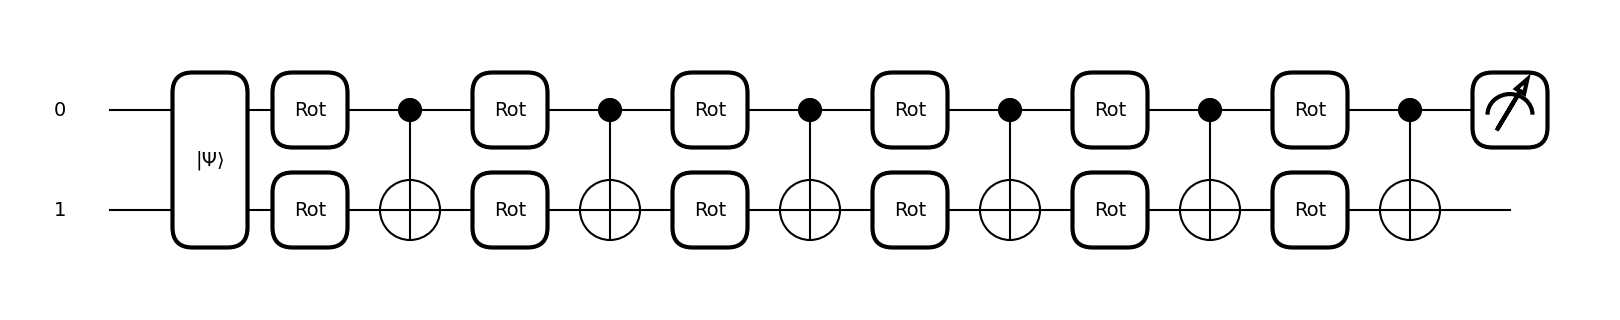

In [36]:
fig, ax = qml.draw_mpl(circuit)(weights_init,X)
fig.show()